# Character Predicting with RNN
---

Codes are writen by simonjisu.
* Simonjisu Blog: https://simonjisu.github.io
* Project Numpy with NN: https://github.com/simonjisu/NUMPYwithNN



## Goal
Writing 'Hello world! Nice to meet you! I love iron-man' using RNN with numpy

|Input||Output|
|:-:|:-:|:-:|
|h|$\rightarrow$|e|
|e|$\rightarrow$|l|
|l|$\rightarrow$|l|
|l|$\rightarrow$|o|
|$\vdots$|$\vdots$|$\vdots$|
|m|$\rightarrow$|a|
|a|$\rightarrow$|n|


## Packages

In [1]:
import os
import sys
dir_path = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(dir_path)

In [2]:
import numpy as np
from common.SimpleRNN import Single_layer_RNN
from common.optimizer import Adam
from common.train_graph import loss_graph
np.random.seed(1234)

## DATA

In [3]:
x = 'hello world! nice to meet you! i love iron-man'

### Encoder

In [4]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x):
        encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        return encoded_data
    
    def decode(self, x, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

Change our data to one-hot encoding data by single character. 

In [5]:
encoder = chr_coding()
encoder.fit(x)
one_hot_data = encoder.encode(x)

print('data shape:', one_hot_data.shape)

data shape: (46, 19)


## Parameters

In [6]:
NUM_EPOCHS = 300
INPUT_SIZE = one_hot_data.shape[1]
OUTPUT_SIZE = one_hot_data.shape[1]
HIDDEN_SIZE = 20
BPTT_TRUNCATE = 5  
# Backpropagation Through Time Truncate: 
# A fixed number of steps to lookback past data in BPTT

## Get Training Datas

In [7]:
train_x = one_hot_data[:-1]
train_y = one_hot_data[1:]

## Call RNN module & Optimizer Setting

Basic Settings of **Single_layer_RNN**

* input_size: input layer size
* hidden_size: hidden layer size
* output_size: output layer size
* bptt_truncate: if you want to use it, use backward_truncate method when you doing backward, default=0
* activation_func: if use "tanh", params will initialize as Xavier, use "relu", initialize as He, default="tanh"

In [8]:
# accuracy calculation function
def get_accuracy(x, test_string):
    bool_ = np.array(list(x))[1:] == np.array(list(test_string))[1:]
    return bool_.sum() / len(bool_)

In [9]:
def train(rnn, optim, option=True):
    """
    option:
    * True: do backward
    * False: do backward_truncate
    """
    total_loss_list = []
    total_acc_list = []
    for epoch in range(NUM_EPOCHS):
        test_string = 'h'
        # forward
        total_loss = rnn.loss(train_x, train_y)

        # backward
        if option:
            rnn.backward()
        else:
            rnn.backward_truncate()

        optim.update(rnn.params, rnn.params_summ)

        # test string
        predicted_idx = rnn.predict(train_x)
        for idx in predicted_idx:
            test_string += encoder.decode(idx)

        # get accuracy
        acc = get_accuracy(x, test_string)

        if epoch % 10 == 0:
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))
        elif epoch == (NUM_EPOCHS-1):
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))

        total_loss_list.append(total_loss)
        total_acc_list.append(acc)
    return total_loss_list, total_acc_list

### Using BPTT

In [10]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE)
optim = Adam()

In [11]:
total_loss_list, total_acc_list = train(rnn, optim, option=True)

#0, Loss: 3.020305, Acc: 0.066667, Test_string: "hyd!uuww!uiowwnn-wwau-wweeiowmiiiwwtiiwnvuiiww"
#10, Loss: 2.899966, Acc: 0.111111, Test_string: "hydia wu!uitwwnn-ywah-wttiiwwmiiiwauiiinvuniiv"
#20, Loss: 2.792653, Acc: 0.133333, Test_string: "hydiaowuviitiwnn-tioowvvtiiwumiiiwauitinauniii"
#30, Loss: 2.693882, Acc: 0.155556, Test_string: "hydioowuviititnw-tioowvvtiiwhviiiwavitiiyuhiii"
#40, Loss: 2.597789, Acc: 0.200000, Test_string: "hydioowuviitityw-tioowvvtioohviiiwavitinouhiii"
#50, Loss: 2.497741, Acc: 0.266667, Test_string: "hyd oowuviitiiyc-tioowvvtioouviiiwovutiyouhiii"
#60, Loss: 2.391550, Acc: 0.311111, Test_string: "hyd oowuvuitiiycetioowvvtioouv iiwovutiyouhiiy"
#70, Loss: 2.284859, Acc: 0.333333, Test_string: "hyyyoowovritiiycetioowvvtiooue iiwovutiyomh-iy"
#80, Loss: 2.177136, Acc: 0.422222, Test_string: "hyyyoowovlttiiycetiooweetiooue i wovutiyomh-iy"
#90, Loss: 2.068271, Acc: 0.466667, Test_string: "hyyyoowowlttiiocettooweetiooue i wovetiyomh-iy"
#100, Loss: 1.959794,

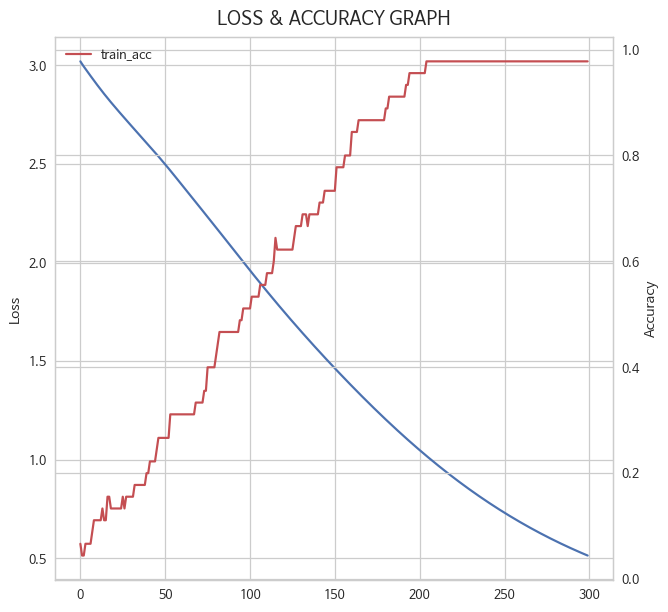

In [12]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using BPTT-Truncate

In [13]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE)
optim = Adam()

In [14]:
total_loss_list, total_acc_list = train(rnn, optim, option=False)

#0, Loss: 3.016440, Acc: 0.022222, Test_string: "hneyvwoittvv!ty!rvvuodchevvyllrthlrhtiuh!rhui-"
#10, Loss: 2.938498, Acc: 0.022222, Test_string: "hneyrworttlvtty!rvvyodchevvyllrthlrctith!rhuid"
#20, Loss: 2.862366, Acc: 0.044444, Test_string: "heeyroorttlittv!l  yolchuv y!lrrtorctith!wcuid"
#30, Loss: 2.778683, Acc: 0.155556, Test_string: "heeyr orrtlrtty!l   mlc     !lrr mr lit !r mir"
#40, Loss: 2.698485, Acc: 0.244444, Test_string: "hee   orrtlr t !l    m       m   mr l   !   i "
#50, Loss: 2.624448, Acc: 0.222222, Test_string: "hee   orrel  t  l                   l   l   i "
#60, Loss: 2.556956, Acc: 0.222222, Test_string: "hee   orrelr t  l                   l   e   i "
#70, Loss: 2.497800, Acc: 0.200000, Test_string: "hee   oooelret  l                   l   e   i "
#80, Loss: 2.444468, Acc: 0.200000, Test_string: "hee   oooelret  l                   l   e   i "
#90, Loss: 2.395250, Acc: 0.222222, Test_string: "hee   oooelret  l                   l   e o in"
#100, Loss: 2.348287,

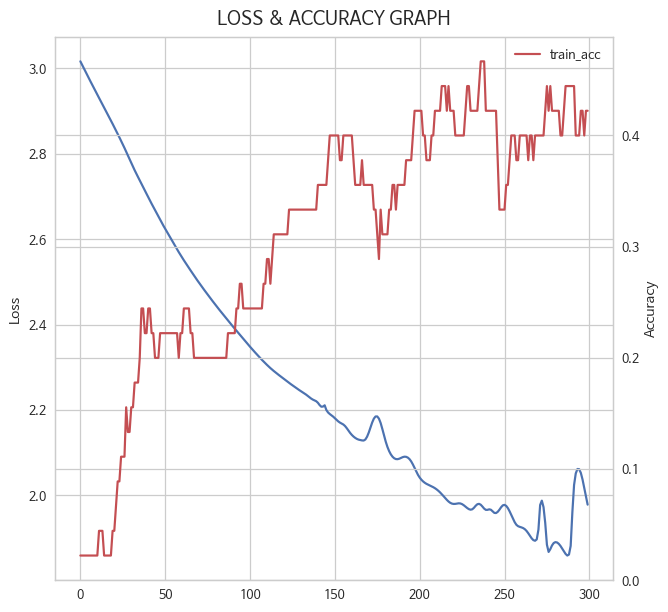

In [15]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using ReLu as activation functions

In [16]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE,
                       activation_func='relu')
optim = Adam()

In [17]:
total_loss_list, total_acc_list = train(rnn, optim, option=True)

#0, Loss: 8.019497, Acc: 0.044444, Test_string: "hlvdwwv hmmvvv ovmvmovoovoovoooooooooooooooooo"
#10, Loss: 3.294571, Acc: 0.044444, Test_string: "hlvdddl il vul  vmvmimilmhud-lhlddddldldwdd d "
#20, Loss: 3.130091, Acc: 0.088889, Test_string: "hledddl -l dul  vmv ililmhldulhl dddl ldwdh d "
#30, Loss: 3.006870, Acc: 0.111111, Test_string: "hledddl -l dul  vmv imilmhel-lhl ld l l wdh   "
#40, Loss: 2.925224, Acc: 0.155556, Test_string: "heedd l -l dul  vmv im lmhel-lhl l  l l wdh e "
#50, Loss: 2.854020, Acc: 0.155556, Test_string: "heedw l -l dul  lmvmil lm elilhl l  l l i h e "
#60, Loss: 2.788940, Acc: 0.177778, Test_string: "heed  l -l dul  lhvmil em el lhe l  l l i h   "
#70, Loss: 2.734830, Acc: 0.177778, Test_string: "heed  l ie dul  l vmil em el lhe l  l l i h   "
#80, Loss: 2.687397, Acc: 0.200000, Test_string: "heen  l ie dul  l vmil em el l e l  l l i h   "
#90, Loss: 2.642981, Acc: 0.200000, Test_string: "heen  l ie dul  l vmil em el l e l  l l i h   "
#100, Loss: 2.599978,

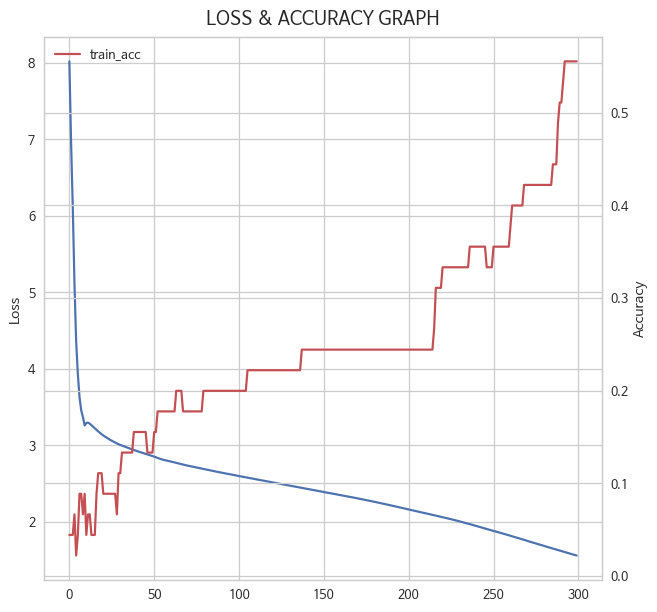

In [18]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

## Check model stablitlity

In [19]:
from nltk.corpus import gutenberg
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [20]:
hamlet_raw = gutenberg.raw('shakespeare-hamlet.txt')[:775]

In [21]:
hamlet_raw

"[The Tragedie of Hamlet by William Shakespeare 1599]\n\n\nActus Primus. Scoena Prima.\n\nEnter Barnardo and Francisco two Centinels.\n\n  Barnardo. Who's there?\n  Fran. Nay answer me: Stand & vnfold\nyour selfe\n\n   Bar. Long liue the King\n\n   Fran. Barnardo?\n  Bar. He\n\n   Fran. You come most carefully vpon your houre\n\n   Bar. 'Tis now strook twelue, get thee to bed Francisco\n\n   Fran. For this releefe much thankes: 'Tis bitter cold,\nAnd I am sicke at heart\n\n   Barn. Haue you had quiet Guard?\n  Fran. Not a Mouse stirring\n\n   Barn. Well, goodnight. If you do meet Horatio and\nMarcellus, the Riuals of my Watch, bid them make hast.\nEnter Horatio and Marcellus.\n\n  Fran. I thinke I heare them. Stand: who's there?\n  Hor. Friends to this ground\n\n   Mar. And Leige-men to the Dane\n\n "

In [22]:
encoder = chr_coding()
encoder.fit(hamlet_raw)
one_hot_data = encoder.encode(hamlet_raw)

print('data shape:', one_hot_data.shape)

data shape: (775, 56)


Hyper Parameters:
* NUM_CHECK = 3
* NUM_EPOCHS = 500
* INPUT_SIZE = 56
* HIDDEN_SIZE = 40
* OUTPUT_SIZE = 56
* BPTT_TRUNCATE = 10

Run 3 times, each model initialze different weights.

Sometimes You can see the gradient overflowed (explode),

this is because when backpropagate,

$$\begin{aligned}
\dfrac{\partial L}{\partial W_{hh}}  
&= \dfrac{\partial L}{\partial Cost_T} \dfrac{\partial Cost_T}{\partial W_{hh}} + \cdots +
\dfrac{\partial L}{\partial Cost_1} \dfrac{\partial Cost_1}{\partial W_{hh}} \\
&= \dfrac{\partial L}{\partial Cost_T} \dfrac{\partial Cost_T}{\partial y_T} \dfrac{\partial y_T}{\partial h_T} \dfrac{\partial h_T}{\partial h_{T-1}}  \cdots \dfrac{\partial h_2}{\partial h_1} \dfrac{\partial h_1}{\partial W_{hh}} +
\cdots + \dfrac{\partial L}{\partial Cost_1} \dfrac{\partial Cost_1}{\partial y_1} \dfrac{\partial y_1}{\partial h_1} \dfrac{\partial h_1}{\partial W_{hh}} \\
&= \dfrac{\partial L}{\partial Cost_T} \dfrac{\partial Cost_T}{\partial y_T} \dfrac{\partial y_T}{\partial h_T} \prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial h_{T-i}} \dfrac{\partial h_1}{\partial W_{hh}} + \cdots + \dfrac{\partial L}{\partial Cost_1} \dfrac{\partial Cost_1}{\partial y_1} \dfrac{\partial y_1}{\partial h_1} \dfrac{\partial h_1}{\partial W_{hh}}
\end{aligned}$$

Watch careful at this part below.

$$\begin{aligned}
\prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial h_{T-i}}
&= \prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial a_{T-i+1}} \dfrac{\partial a_{T-i+1}}{\partial h_{T-i}} \\
&= \prod_{i=1}^{T-1} \dfrac{\partial h_{T-i+1}}{\partial a_{T-i+1}} W_{hh}
\end{aligned}$$

When $W_{hh}$ >1, gradient will be explode, because a number multiplicatied by a number larger than 1 will be infinite if time-step is long enough.

In [23]:
!python3 Character_Predicting_RNN_CV.py

Number of Checking: 3
runned # 0 | model1: tanh + backward | 56.53404116630554 second
runned # 0 | model2: tanh + backward_truncate | 204.9921910762787 second
runned # 0 | model3: relu + backward | 64.7625150680542 second
runned # 1 | model1: tanh + backward | 56.89312505722046 second
runned # 1 | model2: tanh + backward_truncate | 205.00066995620728 second
runned # 1 | model3: relu + backward | 58.86605787277222 second
runned # 2 | model1: tanh + backward | 56.484946966171265 second
runned # 2 | model2: tanh + backward_truncate | 206.12993097305298 second
runned # 2 | model3: relu + backward | 59.013570070266724 second
## model1: tanh + backward ##
Average Score: 0.5551248923341946
Acc_list: [0.70671835 0.25839793 0.7002584 ]
hThe trameli  
  Wame e  i WillirmeShant heare m599]


Acous trimus. Ioouaa chimus

ooter Farnardouand Francisco
two uentieges.

  Barnardot Who's there?
  Fran. No  andeer me: Shand m vncold
youratelee

   Bar. Hondeciur  he ting

   Bran. Nar ando.   Bar. Ho   